In [1]:
if "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random


import matplotlib.pyplot as plt
import seaborn as sns
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

gc.collect()

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

31343

In [3]:
# PCA_ = PCA(n_components=60).fit(X_norm)
# X_PCA = PCA_.transform(X_norm)
# # X_TSNE = TSNE(n_components=60, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
# reducer = umap.UMAP(min_dist=0.9, n_components=60)
# X_UMAP = reducer.fit_transform(X_norm)
# X_batch = np.reshape(X_UMAP, (X_UMAP.shape[0]//5,5,X_UMAP.shape[1]))
# # X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)

In [3]:
root_audios_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_audios.csv"
root_recorders_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_recorders.csv"

audios = pd.read_csv(root_audios_Zamuro, index_col=0)
recorders = pd.read_csv(root_recorders_Zamuro, index_col=0)

def combinar_nombre_ubicacion(row):
    return f"{row['field_number_PR']}_{row['Filename']}"

# Aplicando la función a cada fila del DataFrame para crear la nueva columna
audios['Filename_'] = audios.apply(combinar_nombre_ubicacion, axis=1)

audios.set_index("Filename_", inplace=True)

# AE Model

In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

models = [1,3,5,7,10,20,30,40,50]

accuracies = []
f1_scores = []
recalls = []
for  i, mod_id in enumerate(models):

    X_ae = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/{mod_id}/AE_features_Zamuro.pth",  map_location=torch.device('cpu'))
    X_ae = np.asarray(X_ae)
    y_path = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/{mod_id}/AE_test_path_samples_Zamuro.pth",  map_location=torch.device('cpu'))
    
    y = np.asarray(y_path)
    y_2 = y[:,0]
    for i in range(len(y_2)):
        y_2[i] = y_2[i][0:-2] 
    y_2 = list(y_2)
    y_3 = np.repeat(y_2, 5)
    labels_ae = []
    for i in range(len(y_2)):
        labels_ae.append(audios.loc[y_2[i], "cover"])
        
    X_ae = np.reshape(X_ae, [X_ae.shape[0]//5, 5, X_ae.shape[1]])
        
    X_train, X_test, y_train, y_test = train_test_split(X_ae, labels_ae, test_size=0.2,random_state=0)
    
    X_train = np.reshape(X_train, [X_train.shape[0]*5, X_train.shape[2]])
    X_test = np.reshape(X_test, [X_test.shape[0]*5, X_test.shape[2]])
    
    y_train = np.repeat(y_train,5)
    y_test = np.repeat(y_test,5)
    
    
    
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)

    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)
    
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    recalls.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies.npy", accuracies)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores.npy", f1_scores)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls.npy", recalls)

# X_ae = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/AE_features_Zamuro.pth",  map_location=torch.device('cpu'))
# X_ae = np.asarray(X_ae)
# y_path = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/AE_test_path_samples_Zamuro.pth",  map_location=torch.device('cpu'))

# scaler = StandardScaler().fit(X_ae)
# X_scaled = scaler.transform(X_ae)

# Normalizer_ = Normalizer().fit(X_ae)
# X_norm = Normalizer_.transform(X_ae)


NameError: name 'torch' is not defined

## 5 segments flattened 

In [4]:
X_ae = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/AE_features_Zamuro.pth",  map_location=torch.device('cpu'))
X_ae = np.asarray(X_ae)
y_path = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/AE_test_path_samples_Zamuro.pth",  map_location=torch.device('cpu'))

y = np.asarray(y_path)
y_2 = y[:,0]
for i in range(len(y_2)):
    y_2[i] = y_2[i][0:-2] 
y_2 = list(y_2)
y_3 = np.repeat(y_2, 5)
labels_ae = []
for i in range(len(y_3)):
    labels_ae.append(audios.loc[y_3[i], "cover"])

df_ae = pd.DataFrame(X_ae)
df_ae["y"] = y_3

In [5]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_ae[['location', 'day', 'hour']] =df_ae['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_ae['hour_stage'] =df_ae['hour'].apply(define_hour_stage)
df_ae.set_index("y", inplace=True, drop=False)
df_ae['cover'] = df_ae.index.map(audios['cover'])

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

df_day={}
accuracies_ae = []
f1_scores_ae = []
recalls_ae = []
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ae[df_ae['day'].isin([i])]
    X = np.asarray(df_day.loc[:,0:5183])
    y = np.asarray(df_day.loc[:,"cover"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ae.append(accuracy)
    f1_scores_ae.append(f1_score)
    recalls_ae.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae.npy", accuracies_ae)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae.npy", f1_scores_ae)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae.npy", recalls_ae)

## UNFLAT Mean

print(X_ae.shape)
X_ae_unflat = np.reshape(X_ae, [X_ae.shape[0]//5,5,X_ae.shape[1]])
print(X_ae_unflat.shape)
X_ae_unflat2 = np.reshape(X_ae_unflat, [X_ae_unflat.shape[0], X_ae_unflat.shape[1]*X_ae_unflat.shape[2]])
print(X_ae_unflat2.shape)
X_ae_unflat3 = np.reshape(X_ae_unflat2, [X_ae_unflat2.shape[0], 5, X_ae_unflat2.shape[1]//5])
print(X_ae_unflat3.shape)
X_ae_flat = np.reshape(X_ae_unflat3, [X_ae_unflat3.shape[0]*5,X_ae_unflat3.shape[2]])
print(X_ae_flat.shape)
print((X_ae_flat == X_ae).all())

In [22]:
X_ae_unflat = np.reshape(X_ae, [X_ae.shape[0]//5,5,X_ae.shape[1]])
# X_ae_unflat = X_ae_unflat2.mean(axis=1)
# X_ae_unflat = np.median(X_ae_unflat, axis=1)
X_ae_unflat = np.reshape(X_ae_unflat, [X_ae_unflat.shape[0], X_ae_unflat.shape[1]*X_ae_unflat.shape[2]])
df_ae_unflat = pd.DataFrame(X_ae_unflat)
df_ae_unflat["y"] = y_2

In [27]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_ae_unflat[['location', 'day', 'hour']] =df_ae_unflat['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_ae_unflat['hour_stage'] =df_ae_unflat['hour'].apply(define_hour_stage)
df_ae_unflat.set_index("y", inplace=True, drop=False)
df_ae_unflat['cover'] = df_ae_unflat.index.map(audios['cover'])
df_ae_unflat['rain_FI'] = df_ae_unflat.index.map(audios['rain_FI'])
# df_ae_unflat['habitat'] = df_ae_unflat.index.map(audios['habitat'])
df_ae_unflat = df_ae_unflat[df_ae_unflat['rain_FI'] == 'NO']
df_ae_unflat = df_ae_unflat.dropna()

## All classification

In [30]:
X = np.asarray(df_ae_unflat.loc[:,0:25919])
y = np.asarray(df_ae_unflat.loc[:,"cover"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
y_train = np.repeat(y_train,5)
y_test = np.repeat(y_test,5)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)


confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)

confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")

print(confusion_matrix_norm)

print(confusion_matrix)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["forest", "pasture", "savanna"])

# display matrix
cm_display.plot()
plt.show()



Accuracy: 0.8218396987627757
f1: 0.7627425214690388
recall 0.738430450427017


[[0.13426573 0.04686083 0.01667563]
 [0.01361715 0.56491201 0.0123415 ]
 [0.02843311 0.06023208 0.12266195]]
[[ 8736  3049  1085]
 [  886 36756   803]
 [ 1850  3919  7981]]


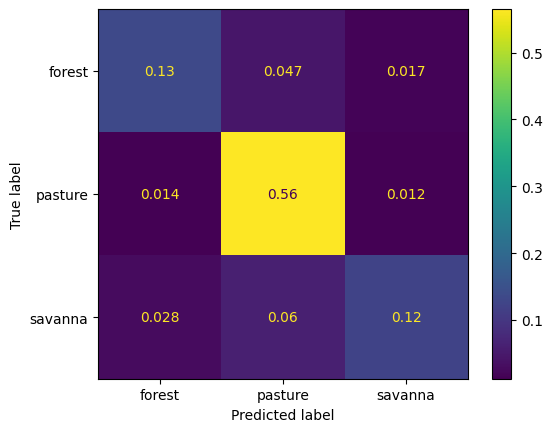

In [31]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)

confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")

print(confusion_matrix_norm)

print(confusion_matrix)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["forest", "pasture", "savanna"])

# display matrix
cm_display.plot()
plt.show()


## Cover Classification

In [17]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

df_day={}
accuracies_ae_unflat_covers = []
f1_scores_ae_unflat_covers = []
recalls_ae_unflat_covers = []
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ae_unflat[df_ae_unflat['day'].isin([i])]
    X = np.asarray(df_day.loc[:,0:25919])
    y = np.asarray(df_day.loc[:,"cover"])
    X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
    X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
    y_train = np.repeat(y_train,5)
    y_test = np.repeat(y_test,5)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ae_unflat_covers.append(accuracy)
    f1_scores_ae_unflat_covers.append(f1_score)
    recalls_ae_unflat_covers.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae_unflat_covers.npy", accuracies_ae_unflat_covers)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae_unflat_covers.npy", f1_scores_ae_unflat_covers)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae_unflat_covers.npy", recalls_ae_unflat_covers)

(922, 5, 5184) (231, 5, 5184)
Accuracy: 0.8874458874458875
f1: 0.8202336179968279
recall 0.7784285633342237
(4028, 5, 5184) (1008, 5, 5184)
Accuracy: 0.8406746031746032
f1: 0.7760975851166583
recall 0.7393010181734642
(6267, 5, 5184) (1567, 5, 5184)
Accuracy: 0.8255264837268667
f1: 0.7753539486730737
recall 0.7487375898604104
(6960, 5, 5184) (1740, 5, 5184)
Accuracy: 0.8295402298850575
f1: 0.772362826427761
recall 0.7508791174330485
(6982, 5, 5184) (1746, 5, 5184)
Accuracy: 0.8239404352806414
f1: 0.7644580696611154
recall 0.7384025674843651
(6164, 5, 5184) (1541, 5, 5184)
Accuracy: 0.771966255678131
f1: 0.6961359076327854
recall 0.6721932723419181
(4882, 5, 5184) (1221, 5, 5184)
Accuracy: 0.8552006552006552
f1: 0.8046740106409622
recall 0.7870620258788471
(5392, 5, 5184) (1348, 5, 5184)
Accuracy: 0.8370919881305638
f1: 0.790777378552724
recall 0.7706063991477358
(5698, 5, 5184) (1425, 5, 5184)
Accuracy: 0.8394385964912281
f1: 0.7922193930883209
recall 0.7662406515562691
(3542, 5, 5184)

## Hour Stage Classification

In [10]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

df_day={}
accuracies_ae_unflat_hours = []
f1_scores_ae_unflat_hours = []
recalls_ae_unflat_hours = []
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ae_unflat[df_ae_unflat['day'].isin([i])]
    X = np.asarray(df_day.loc[:,0:25919])
    y = np.asarray(df_day.loc[:,"hour_stage"])
    X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
    X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
    y_train = np.repeat(y_train,5)
    y_test = np.repeat(y_test,5)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ae_unflat_hours.append(accuracy)
    f1_scores_ae_unflat_hours.append(f1_score)
    recalls_ae_unflat_hours.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae_unflat_hours.npy", accuracies_ae_unflat_hours)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae_unflat_hours.npy", f1_scores_ae_unflat_hours)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae_unflat_hours.npy", recalls_ae_unflat_hours)

Accuracy: 0.9376623376623376
f1: 0.612615823235923
recall 0.61177304964539
Accuracy: 0.8823412698412698
f1: 0.8006949569747902
recall 0.779771722709968
Accuracy: 0.8611359285258455
f1: 0.7927775970404195
recall 0.7802045378380269
Accuracy: 0.8970114942528735
f1: 0.8613218632952521
recall 0.8495485635108841
Accuracy: 0.900114547537228
f1: 0.8606986275978993
recall 0.8462843499011427
Accuracy: 0.8717715768981181
f1: 0.840594870966723
recall 0.8254954691120387
Accuracy: 0.8301392301392302
f1: 0.6684664588424942
recall 0.6577380945915365
Accuracy: 0.8244807121661721
f1: 0.6574266160407841
recall 0.6681496018236107
Accuracy: 0.8679298245614036
f1: 0.8362010930974281
recall 0.8280783382386101
Accuracy: 0.8584650112866817
f1: 0.8407648390230474
recall 0.8374125362291739
Accuracy: 0.8349442379182156
f1: 0.8021718306944304
recall 0.7976693944353519


### Autoencoders Features and Labels using independent segments

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ae, labels_ae, test_size=0.2,random_state=0)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

### Autoencoders Features and Labels using 5 segments of the audio

In [ ]:
X_batch = np.reshape(X_ae, (X_ae.shape[0]//5,5,X_ae.shape[1]))
y_batch = np.reshape(y_ae, (y_ae.shape[0]//5, 5))

In [ ]:
y_3 == y_path[:,0]

In [ ]:
len(labels_ai), y_path[0].shape

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_batch, y_path, test_size=0.2,random_state=0)

X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1])

labels_train = []
for i in range(len(y_train)):
    labels_train.append(audios.loc[y_train[i], "cover"])
labels_test = []
for i in range(len(y_test)):
    labels_test.append(audios.loc[y_test[i], "cover"])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, labels_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(labels_test, y_pred_rf)
f1_score = metrics.f1_score(labels_test, y_pred_rf, average="macro")
recall = metrics.recall_score(labels_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

# Autoencoders Features and Labels using voting labels

In [ ]:
y_pred_rf2 = np.asarray(y_pred_rf)
y_pred_rf2 = np.reshape(y_pred_rf2,(y_pred_rf2.shape[0]//5,5))
y_test2 = np.asarray(labels_test)
y_test2 = np.reshape(y_test2,(y_test2.shape[0]//5,5))

def most_frequent(List):
    return max(set(List), key = List.count)

labels_test2 = []
labels_pred = []
for i in range(len(y_pred_rf2)):
    labels_pred.append(most_frequent(list(y_pred_rf2[i])))
    labels_test2.append(most_frequent(list(y_test2[i])))
accuracy_ae = metrics.accuracy_score(labels_test2, labels_pred)
f1_score_ae = metrics.f1_score(labels_test2, labels_pred, average="macro")
recall_ae = metrics.recall_score(labels_test2, labels_pred, average="macro")

print("Accuracy:", accuracy_ae)
print("f1:", f1_score_ae)
print("recall", recall_ae)